## Sommaire

- <a href="#C1">1. Préparation des données </a>

- <a href="#C2">2. Prétraitement des données</a>
 
- <a href="#C3">3. Kmeans (variables RFM)</a>

- <a href="#C4">4. Kmeans (ajout variables d'intérêt)</a>

- <a href="#C5">5. Clustering hiérarchique</a>

- <a href="#C6">6. DBSCAN</a>

## **<a name="C1">1. Préparation des données</a>**

In [145]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from time import time
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, make_scorer
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import matplotlib.lines as mlines
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import fastcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import FunctionTransformer
from matplotlib.lines import Line2D


Importation des deux fichiers générés dans le notebook exploratoire: le fichier data qui ne contient que les variables RFM, et le fichier data_seg obtenu après le feature engineering

In [146]:
data = pd.read_csv("data_RFM.csv", sep=',')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92988 entries, 0 to 92987
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  92988 non-null  object 
 1   recurrence_days     92988 non-null  int64  
 2   frequency           92988 non-null  int64  
 3   total_amount        92988 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.8+ MB


In [147]:
data_seg = pd.read_csv("data_segmentation.csv", sep=',')
data_seg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92988 entries, 0 to 92987
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_unique_id      92988 non-null  object 
 1   unique_orders           92988 non-null  int64  
 2   average_review_score    92988 non-null  float64
 3   total_freight           92988 non-null  float64
 4   number_of_payments      92988 non-null  int64  
 5   total_installments      92988 non-null  int64  
 6   average_payment_value   92988 non-null  float64
 7   average_delivery_time   91473 non-null  float64
 8   technology_electronics  92988 non-null  float64
 9   book_cd_media_art       92988 non-null  float64
 10  clothing_accessories    92988 non-null  float64
 11  tools                   92988 non-null  float64
 12  furnitures              92988 non-null  float64
 13  baby_toys               92988 non-null  float64
 14  home                    92988 non-null

## **<a name="C2">2. Prétraitement des données</a>**

In [148]:
data.isnull().sum()

customer_unique_id    0
recurrence_days       0
frequency             0
total_amount          0
dtype: int64

In [149]:
data = data.drop(columns=['customer_unique_id'])

Normalisation des données

In [150]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), data.select_dtypes(include=['number']).columns)
    ])

## **<a name="C3">3. Kmeans (variables RFM)</a>**

### Méthode du coude

In [151]:
X = data.copy()

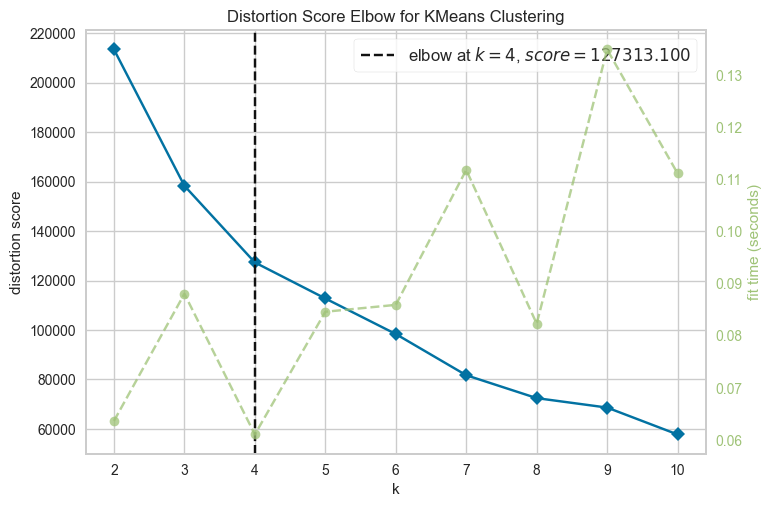

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [152]:
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(3,6)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

### Indice de la silhouette

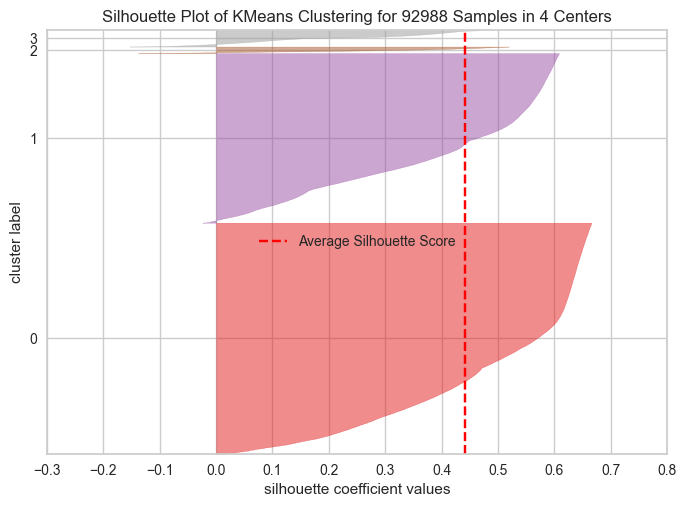

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 92988 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [153]:
K = 4

silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

### Métriques

In [154]:
metrics_dict = []

for n_clusters in range(3, 6):
    clustering_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('kmeans', KMeans(n_clusters=n_clusters, init='k-means++', random_state=42))
    ])
    
    clusters = clustering_pipeline.fit_predict(X)

    kmeans_model = clustering_pipeline.named_steps['kmeans']

    transformed_data = clustering_pipeline.named_steps['preprocessor'].transform(X)

    silhouette_avg = silhouette_score(transformed_data, clusters)
    db_index = davies_bouldin_score(transformed_data, clusters)
    ch_index = calinski_harabasz_score(transformed_data, clusters)
    inertia = kmeans_model.inertia_

    cluster_counts = pd.Series(clusters).value_counts().sort_index()

    cluster_counts_str = ', '.join(f'Cluster {i}: {count}' for i, count in cluster_counts.items())

    metrics_dict.append({
        'Number of Clusters': n_clusters,
        'Silhouette Score': round(silhouette_avg, 2),
        'Davies-Bouldin Index': round(db_index, 2),
        'Calinski-Harabasz Index': round(ch_index, 2),
        'Inertia': round(inertia, 2),
        'Cluster Counts': cluster_counts_str
    })

metrics_df = pd.DataFrame(metrics_dict)

metrics_df

,Number of Clusters,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Inertia,Cluster Counts
0,3,0.42,1.06,35437.39,158302.92,"Cluster 0: 51524, Cluster 1: 3510, Cluster 2: ..."
1,4,0.44,0.85,36919.44,127313.72,"Cluster 0: 50757, Cluster 1: 1428, Cluster 2: ..."


Interprétation:
- Le score de silhouette évalue la qualité des clusters en mesurant à la fois la proximité des points à leur propre cluster et la distance des points aux autres clusters. Un score supérieur à 0.5 est généralement considéré comme bon. 
- Le DBI évalue la compacité des clusters et la séparation entre eux. Un DBI proche de 0 suggère des clusters bien définis, tandis qu'un DBI élevé indique des clusters qui sont proches les uns des autres ou qui se chevauchent. 
- L'indice de Calinski-Harabasz mesure le rapport entre la dispersion intra-cluster et la dispersion inter-cluster. Un score élevé indique que les clusters sont compacts et bien séparés.
- L'inertie mesure dans quelle mesure les points d'un cluster sont proches de leur centroïde. Une inertie faible signifie que les points sont proches de leur centroïde, ce qui est souhaitable. 

Choix du nombre de clusters: 4

### Caractérisation des clusters

In [159]:
X_scaled = preprocessor.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)


X["kmeans_label"] = kmeans_labels

X_clusters = X.groupby("kmeans_label").mean()

df_clusters_summary = pd.DataFrame(X_clusters).reset_index()
df_clusters_summary = df_clusters_summary.round(2)

print("Tableau des moyennes des caractéristiques par cluster :")
df_clusters_summary

Tableau des moyennes des caractéristiques par cluster :


,kmeans_label,recurrence_days,frequency,total_amount
0,0,131.63,1.11,119.86
1,1,238.27,1.49,1489.16
2,2,392.10,1.12,121.62
3,3,236.41,4.16,309.98


Visualisation 3D des clusters

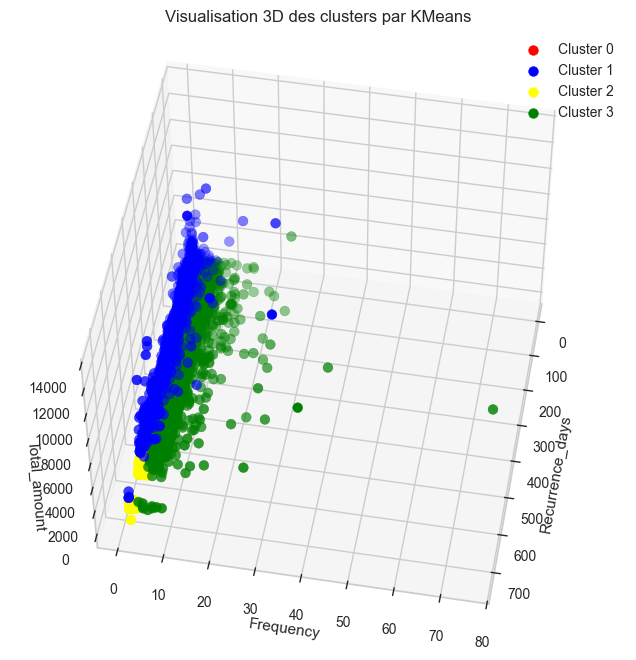

In [156]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

unique_labels = sorted(X['kmeans_label'].unique())
color_map = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}

for cluster_label in unique_labels:
    cluster_data = X[X['kmeans_label'] == cluster_label]
    ax.scatter(cluster_data.iloc[:, 0],
               cluster_data.iloc[:, 1],
               cluster_data.iloc[:, 2],
               c=color_map[cluster_label], label=f'Cluster {cluster_label}', s=50)

ax.set_xlabel('Recurrence_days')
ax.set_ylabel('Frequency')
ax.set_zlabel('Total_amount')

ax.legend()

ax.set_title('Visualisation 3D des clusters par KMeans')

ax.view_init(elev=50, azim=10)

plt.show()


Caractérisation métier des clusters

/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_21821/3749904619.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_21821/3749904619.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_21821/3749904619.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




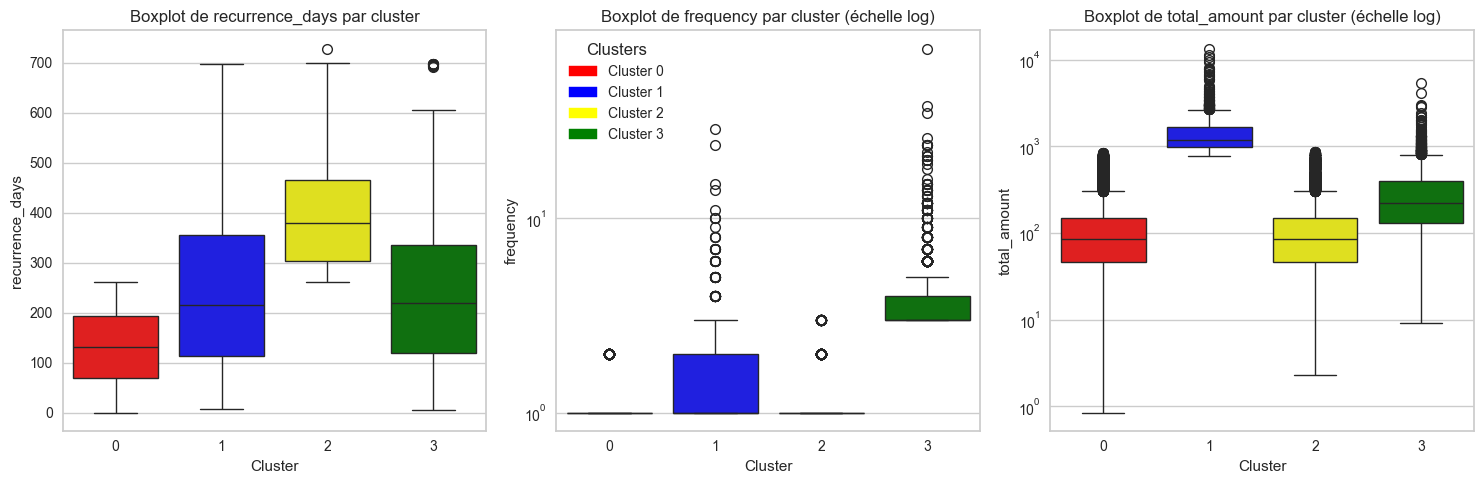

In [163]:
custom_palette = ['red', 'blue', 'yellow', 'green']  

plt.figure(figsize=(15, 5))

variables = X.columns[:-1]  

palette_mapping = {0: 'red', 1: 'blue', 2: 'yellow', 3: 'green'}

for i, variable in enumerate(variables):
    plt.subplot(1, len(variables), i + 1)
    ax = sns.boxplot(x='kmeans_label', y=variable, data=X, palette=custom_palette)
    
    if variable in ['frequency', 'total_amount']:
        ax.set(yscale='log')
        title = f'Boxplot de {variable} par cluster (échelle log)'
    else:
        title = f'Boxplot de {variable} par cluster'
    
    plt.title(title)
    plt.xlabel('Cluster')
    plt.ylabel(variable)
    
    if i == 1:
        legend_handles = [Patch(color=palette_mapping[label], label=f'Cluster {label}') for label in palette_mapping.keys()]
        plt.legend(handles=legend_handles, title="Clusters", loc='upper left')

plt.tight_layout()
plt.show()


Description des clusters:

- Cluster 0 : Ce cluster regroupe des clients occasionnels qui reviennent sur le site environ tous les 4 mois. Ils effectuent peu d'achats et dépensent généralement peu. Ils pourraient être des clients qui achètent uniquement lorsqu'ils trouvent une promotion ou un produit spécifique.

- Cluster 1: Ce cluster représente des clients qui achètent très rarement (environ tous les 8 mois), mais lorsqu'ils le font, ils dépensent beaucoup. Ce groupe pourrait correspondre à des acheteurs de gros articles ou de produits de luxe qui nécessitent des achats moins fréquents mais de valeur élevée.

- Cluster 2: Les clients de ce cluster reviennent tous les 7 mois environ et effectuent plus d'une transaction par période. Ils dépensent de manière modérée. Ils pourraient représenter des acheteurs réguliers de produits d'une certaine valeur, comme des articles saisonniers ou semi-réguliers.

- Cluster 3: Ce cluster est composé de clients très peu actifs qui achètent une fois par an ou moins souvent. Ils dépensent également peu, ce qui pourrait indiquer qu'ils ne sont pas très engagés ou qu'ils ne trouvent pas suffisamment de valeur sur le site pour revenir plus souvent.

Finalement: 
- Cluster 0 : Clients occasionnels, petits dépensiers.
- Cluster 1 : Acheteurs rares mais gros dépensiers.
- Cluster 2 : Clients modérément réguliers avec une dépense moyenne.
- Cluster 3 : Clients très rares, avec une faible valeur client.


Ajout de variables d'intérêt pour observer si le clustering est de meilleur qualité et si la caractérisation métier des clusters est optimisée

## **<a name="C4">4. Kmeans (ajout variables d'intérêt)</a>**

### Préparation des données

In [164]:
data = pd.read_csv("data_RFM.csv", sep=',')

Sélection de variables d'intérêt du fichier data_seg

In [165]:
data_seg_reduced = data_seg[['customer_unique_id', 'average_review_score']]#, 'total_installments', 'average_delivery_time', 'number_of_payments', 'payment_type_count']]
data_new = pd.merge(data, data_seg_reduced, on='customer_unique_id', how='left')

In [166]:
data_new = data_new.drop(columns=['customer_unique_id'])
#data_new=data_new.dropna(subset=['average_delivery_time'])

In [167]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), data_new.select_dtypes(include=['number']).columns)
    ])

In [168]:
X = data_new.copy()

### Méthode du coude

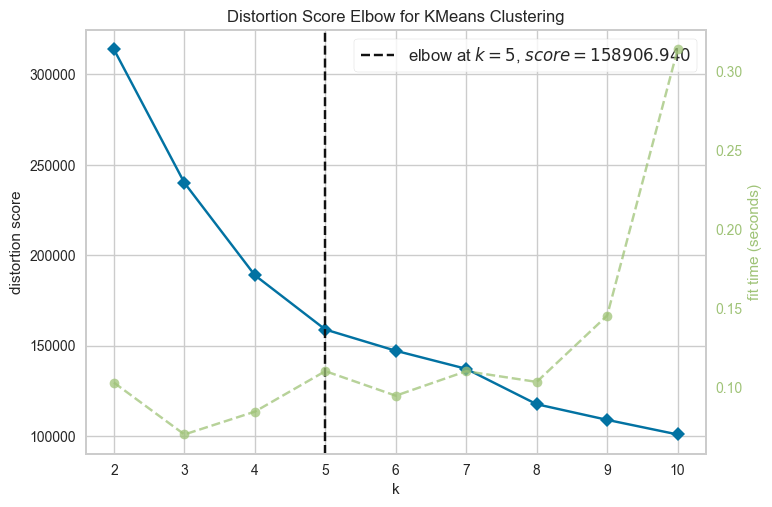

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [169]:
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(3,6)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()


### Méthode de la silhouette

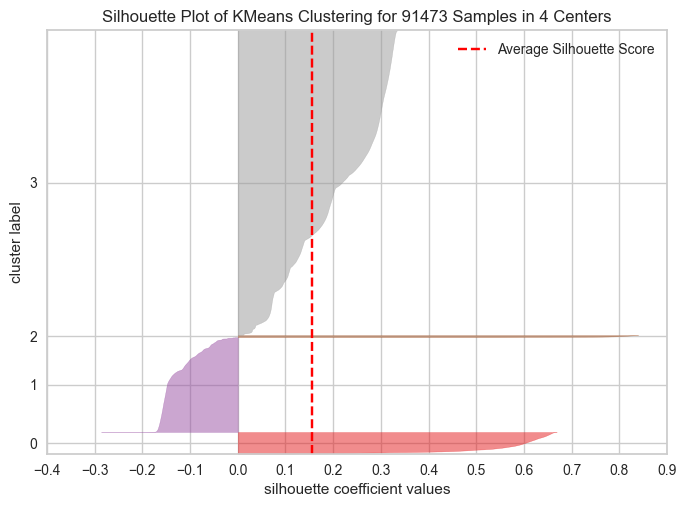

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 91473 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
K = 4

silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

### Métriques

In [172]:
metrics_dict = []

for n_clusters in range(3, 5):
    clustering_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('kmeans', KMeans(n_clusters=n_clusters, init='k-means++', random_state=42))
    ])
    
    clusters = clustering_pipeline.fit_predict(X)

    kmeans_model = clustering_pipeline.named_steps['kmeans']

    transformed_data = clustering_pipeline.named_steps['preprocessor'].transform(X)

    silhouette_avg = silhouette_score(transformed_data, clusters)
    db_index = davies_bouldin_score(transformed_data, clusters)
    ch_index = calinski_harabasz_score(transformed_data, clusters)
    inertia = kmeans_model.inertia_

    cluster_counts = pd.Series(clusters).value_counts().sort_index()

    cluster_counts_str = ', '.join(f'Cluster {i}: {count}' for i, count in cluster_counts.items())

    metrics_dict.append({
        'Number of Clusters': n_clusters,
        'Silhouette Score': round(silhouette_avg, 2),
        'Davies-Bouldin Index': round(db_index, 2),
        'Calinski-Harabasz Index': round(ch_index, 2),
        'Inertia': round(inertia, 2),
        'Cluster Counts': cluster_counts_str
    })

metrics_df_1 = pd.DataFrame(metrics_dict)

metrics_df_1

,Number of Clusters,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Inertia,Cluster Counts
0,3,0.39,1.19,24775.17,242648.33,"Cluster 0: 70008, Cluster 1: 19734, Cluster 2:..."
1,4,0.37,1.10,30028.63,188920.59,"Cluster 0: 42309, Cluster 1: 16201, Cluster 2:..."


### Caractérisation des clusters

In [173]:
X_scaled = preprocessor.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)


X["kmeans_label"] = kmeans_labels

X_clusters = X.groupby("kmeans_label").mean()

df_clusters_summary = pd.DataFrame(X_clusters).reset_index()
df_clusters_summary = df_clusters_summary.round(2)

print("Tableau des moyennes des caractéristiques par cluster :")
df_clusters_summary

Tableau des moyennes des caractéristiques par cluster :


,kmeans_label,recurrence_days,frequency,total_amount,average_review_score
0,0,125.53,1.13,120.77,4.68
1,1,240.88,1.26,135.68,1.66
2,2,243.12,3.80,955.83,3.91
3,3,396.58,1.14,123.10,4.63


/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_21821/2114690228.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_21821/2114690228.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_21821/2114690228.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_21821/2114690228.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the 

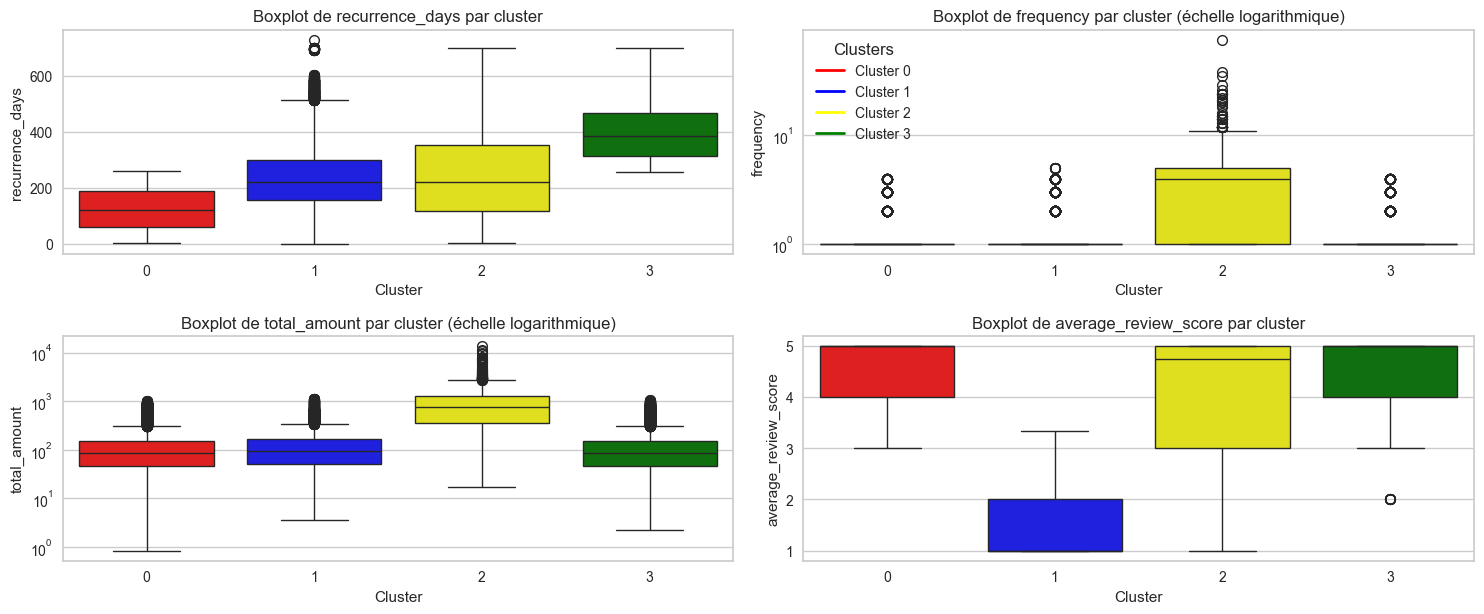

In [180]:
plt.figure(figsize=(15, 12))

variables = X.columns[:-1]

for i, variable in enumerate(variables):
    plt.subplot(4, 2, i + 1)
    
    sns.boxplot(x='kmeans_label', y=variable, data=X, palette=custom_palette)
    
    if variable in ['frequency', 'total_amount']:
        plt.title(f'Boxplot de {variable} par cluster (échelle logarithmique)')
        plt.yscale('log')
    else:
        plt.title(f'Boxplot de {variable} par cluster')
    
    plt.xlabel('Cluster')
    plt.ylabel(variable)
    
    if i == 1:
        labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
        handles = [plt.Line2D([0], [0], color=color, lw=2) for color in custom_palette]
        
        plt.legend(handles, labels, title='Clusters', loc='upper left')

plt.tight_layout()
plt.show()



- Cluster 0: les clients du Cluster 0 sont des clients récurrents avec une fréquence d'achat faible mais avec un montant total d'achat moyen et une satisfaction élevée
- Cluster 1: les clients du Cluster 1 ont une récurrence d'achat modérée et un montant total élevé, mais leur niveau de satisfaction est très bas
- Cluster 2: les clients du Cluster 2 ont une fréquence de récurrence faible et un montant total d'achat bas, mais leur satisfaction est la plus élevée parmi tous les clusters.
- Cluster 3: les clients du Cluster 3 ont une récurrence d'achat modérée avec une fréquence plus élevée et un montant total d'achat élevé, tout en ayant un niveau de satisfaction élevé.

Visualisation 3D des clusters

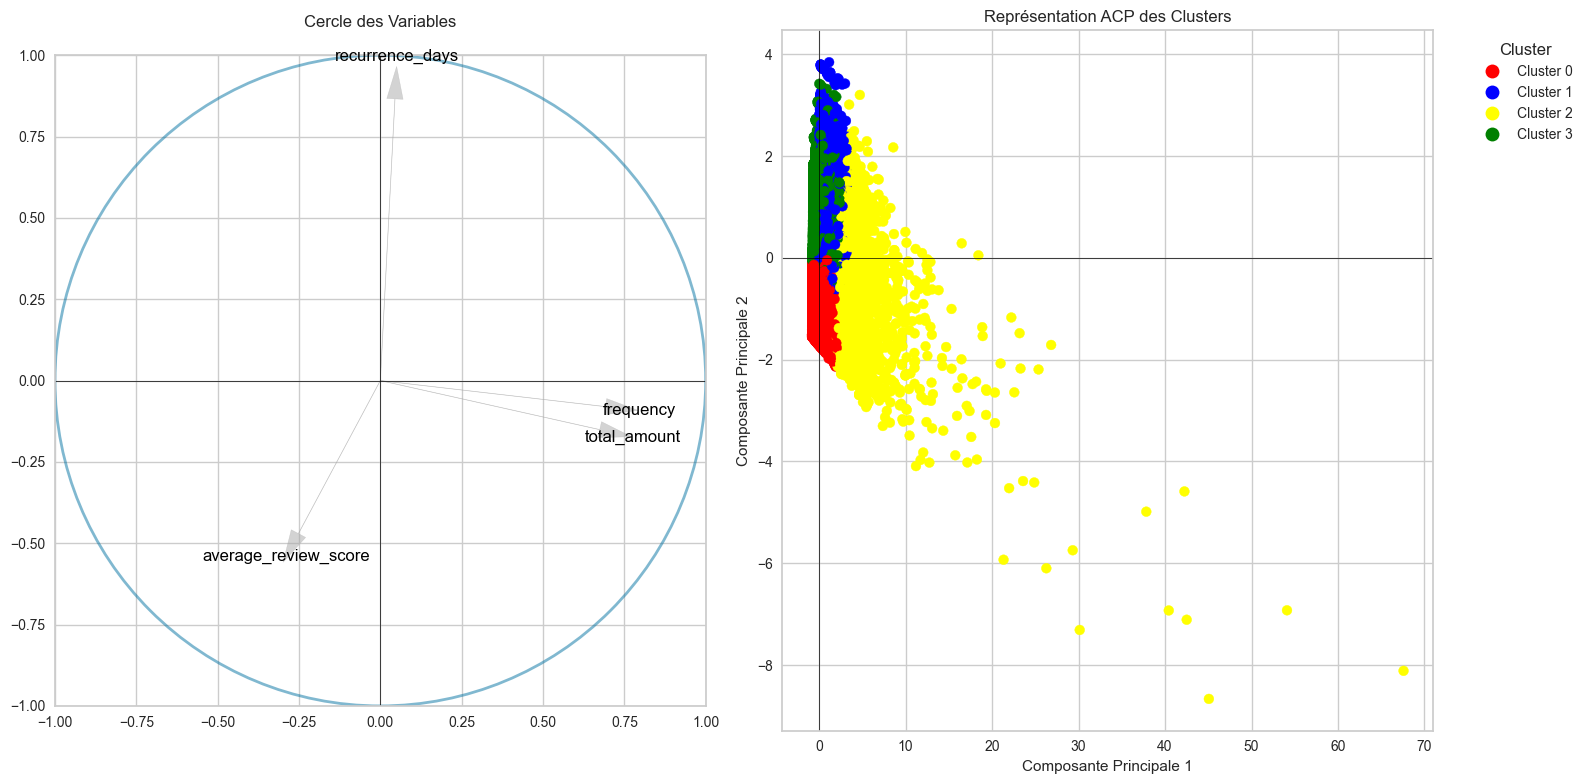

In [181]:
X = data_new.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_df)

kmeans = KMeans(n_clusters=4, random_state=42)  
kmeans_labels = kmeans.fit_predict(X_scaled_df)

X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
X_pca_df['kmeans_label'] = kmeans_labels

components = pca.components_

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].set_title('Cercle des Variables', pad=20)

circle_radius = 1
for i, feature in enumerate(X_scaled_df.columns):
    axs[0].arrow(0, 0, components[0, i], components[1, i], color='darkgrey', alpha=0.5, head_width=0.05, head_length=0.1)
    axs[0].text(components[0, i] * 1.15, components[1, i] * 1.15, feature, color='black', ha='center', va='center')

circle = plt.Circle((0, 0), circle_radius, color='b', fill=False, alpha=0.5, linewidth=2)
axs[0].add_artist(circle)
axs[0].set_xlim(-circle_radius, circle_radius)
axs[0].set_ylim(-circle_radius, circle_radius)
axs[0].set_aspect('equal')
axs[0].axhline(0, color='black', linewidth=0.5)
axs[0].axvline(0, color='black', linewidth=0.5)
axs[0].grid(True)

colors = {0: 'red', 1: 'blue', 2: 'yellow', 3: 'green'}
X_pca_df['color'] = X_pca_df['kmeans_label'].map(colors)

scatter = axs[1].scatter(X_pca_df['PC1'], X_pca_df['PC2'], c=X_pca_df['color'], s=50)
axs[1].set_title('Représentation ACP des Clusters')
axs[1].set_xlabel('Composante Principale 1')
axs[1].set_ylabel('Composante Principale 2')
axs[1].axhline(0, color='black', linewidth=0.5)
axs[1].axvline(0, color='black', linewidth=0.5)
axs[1].grid(True)

legend_labels = [f'Cluster {i}' for i in range(len(np.unique(kmeans_labels)))]
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10) for i in range(len(legend_labels))]
axs[1].legend(handles=handles, labels=legend_labels, title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


Description des clusters:
- Cluster 0: Ce cluster semble regrouper des transactions avec une fréquence d'achat faible (1.00), mais avec des montants totaux et des évaluations relativement élevés. Les clients dans ce cluster ont des périodes de récurrence modérées et utilisent peu de moyens de paiement différents. Cela pourrait indiquer des clients occasionnels mais très satisfaits, avec des achats peu fréquents mais de grande qualité.

- Cluster 1: Ce cluster inclut des clients qui achètent un peu plus souvent (1.54 fois en moyenne) et dépensent davantage par transaction (363.78 en moyenne). Ils ont également des délais de livraison plus longs et utilisent plus souvent des paiements échelonnés. Les clients de ce cluster pourraient être des acheteurs réguliers qui préfèrent les options de paiement différé et sont prêts à attendre plus longtemps pour leurs produits.

- Cluster 2: Les clients de ce cluster ont une fréquence d'achat similaire à celle du Cluster 0 (1.00), mais avec un montant total plus bas et une note de revue beaucoup plus faible (1.64). Ils utilisent également un nombre plus élevé d'installments et ont des délais de livraison beaucoup plus longs. Ce cluster pourrait représenter des clients insatisfaits qui achètent moins fréquemment et sont moins enclins à recommander les produits ou services.

- Cluster 3: Ce cluster a une fréquence d'achat similaire à celle du Cluster 0 et du Cluster 2 (1.00), mais les clients dépensent des montants légèrement plus élevés par transaction que dans le Cluster 0 et obtiennent une meilleure note moyenne. Les clients ont des délais de livraison plus courts que ceux du Cluster 2 et utilisent généralement des options de paiement échelonné. Ce cluster pourrait représenter des clients très satisfaits qui achètent moins souvent mais avec une grande fidélité et satisfaction.

Finalement: 
- Cluster 0 : Clients occasionnels mais satisfaits, achats peu fréquents avec de bonnes évaluations et peu de types de paiements.
- Cluster 1 : Acheteurs réguliers avec de gros montants de dépenses, préfèrent les paiements échelonnés et acceptent des délais de livraison plus longs.
- Cluster 2 : Clients insatisfaits avec des achats moins fréquents, faibles montants totaux, et délais de livraison longs.
- Cluster 3 : Clients satisfaits qui dépensent un peu plus que les clients du Cluster 0, mais restent fidèles avec des évaluations élevées et des délais de livraison raisonnables.

## **<a name="C5">5. Clustering ascendantes hiérarchique</a>**

### Préparation des données

Echantillonage du jeu de données (car jeu de données volumineux avec plus de 90 000 clients)

In [182]:
data = pd.read_csv("data_RFM.csv", sep=',')

In [183]:
data_bis_bis = data.sample(n=20000, random_state=42)
data_bis_bis = data_bis_bis.drop(columns=['customer_unique_id'])

In [184]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), data_bis_bis.select_dtypes(include=['number']).columns)
    ])

In [185]:
X = data_bis_bis.copy()
X_scaled = preprocessor.fit_transform(X)


### Matrice de distance et dendogramme

In [186]:
Z = fastcluster.linkage_vector(X_scaled, method='ward')

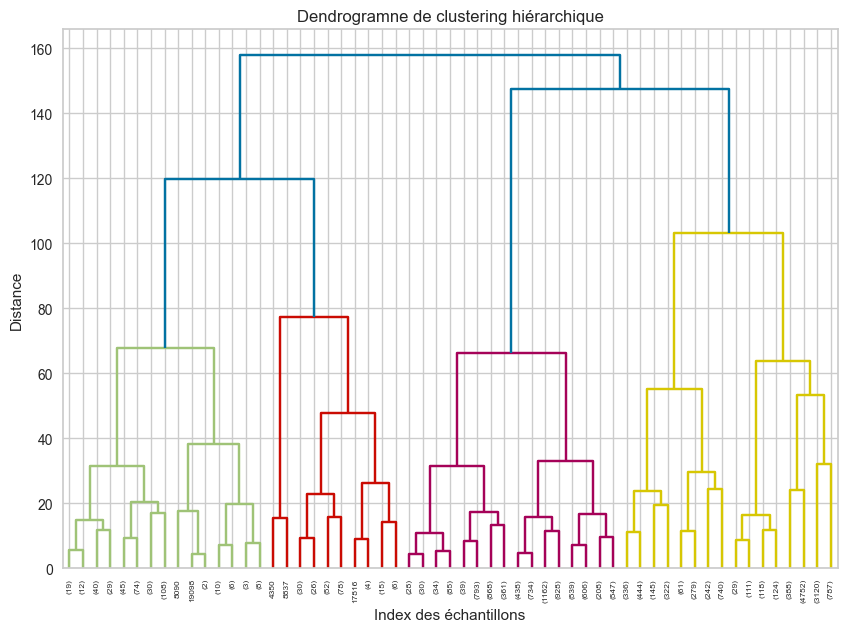

In [187]:
plt.figure(figsize=(10, 7))
dendrogram(Z, truncate_mode='level', p=5)  
plt.title('Dendrogramne de clustering hiérarchique')
plt.xlabel('Index des échantillons')
plt.ylabel('Distance')
plt.show()

### Détermination des métriques

In [ ]:
def perform_clustering(n_clusters, X_scaled):
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    
    labels = hierarchical.fit_predict(X_scaled)
    
    silhouette_avg = silhouette_score(X_scaled, labels)
    db_index = davies_bouldin_score(X_scaled, labels)
    ch_index = calinski_harabasz_score(X_scaled, labels)
    
    cluster_counts = pd.Series(labels).value_counts()
    cluster_counts_str = ', '.join([f"Cluster {i}: {count}" for i, count in cluster_counts.items()])
    
    return {
        'Number of Clusters': n_clusters,
        'Silhouette Score': round(silhouette_avg, 2),
        'Davies-Bouldin Index': round(db_index, 2),
        'Calinski-Harabasz Index': round(ch_index, 2),
        'Inertia': 'N/A',  
        'Cluster Counts': cluster_counts_str
    }

results = []

for n_clusters in range(3, 7):
    result = perform_clustering(n_clusters, X_scaled)
    results.append(result)

metrics_df_3 = pd.DataFrame(results)

metrics_df_3

,Number of Clusters,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Inertia,Cluster Counts
0,3,0.42,0.77,8184.09,N/A,"Cluster 0: 10716, Cluster 2: 8739, Cluster 1: 545"
1,4,0.47,0.73,10097.77,N/A,"Cluster 0: 9889, Cluster 2: 8739, Cluster 3: 8..."
2,5,0.43,0.72,9785.58,N/A,"Cluster 2: 8739, Cluster 3: 6032, Cluster 4: 3..."
3,6,0.43,0.60,10339.60,N/A,"Cluster 2: 8739, Cluster 3: 6032, Cluster 4: 3..."


In [188]:
k = 4
hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward')
labels = hierarchical.fit_predict(X_scaled)

### Caractérisation des clusters

In [189]:
data2=data_bis_bis.copy()
data2['hierarchical_cluster'] = labels
df_clusters_summary_3 = data2.groupby('hierarchical_cluster').mean()
df_clusters_summary_3 = df_clusters_summary_3.round(2)
print("Tableau des moyennes des caractéristiques par cluster :")
df_clusters_summary_3

Tableau des moyennes des caractéristiques par cluster :


,recurrence_days,frequency,total_amount
hierarchical_cluster,,,
0,154.37,1.26,162.75
1,290.12,1.49,1986.59
2,360.62,1.00,81.04
3,260.80,5.28,410.75


Visualisation 3D des clusters

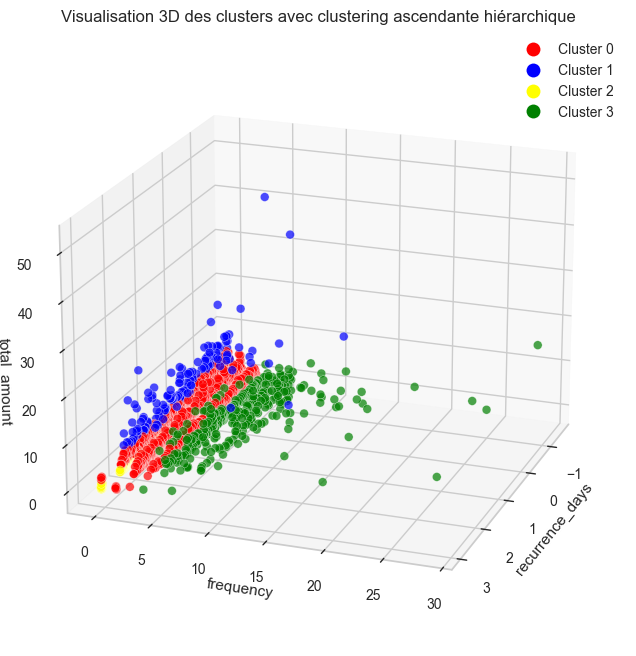

In [190]:
cluster_colors = ['red', 'blue', 'yellow', 'green']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = X_scaled[:, 0]
y = X_scaled[:, 1]
z = X_scaled[:, 2]

colors = [cluster_colors[label] for label in labels]

scatter = ax.scatter(x, y, z, c=colors, s=40, alpha=0.7, edgecolors='w')

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, linestyle='') for color in cluster_colors]
labels_legend = [f'Cluster {i}' for i in range(len(cluster_colors))]
ax.legend(handles, labels_legend)

ax.set_xlabel('recurrence_days')
ax.set_ylabel('frequency')
ax.set_zlabel('total_amount')

ax.view_init(elev=20, azim=20)  

ax.set_title('Visualisation 3D des clusters avec clustering ascendante hiérarchique')
plt.show()

/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_21821/4235098096.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_21821/4235098096.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_21821/4235098096.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




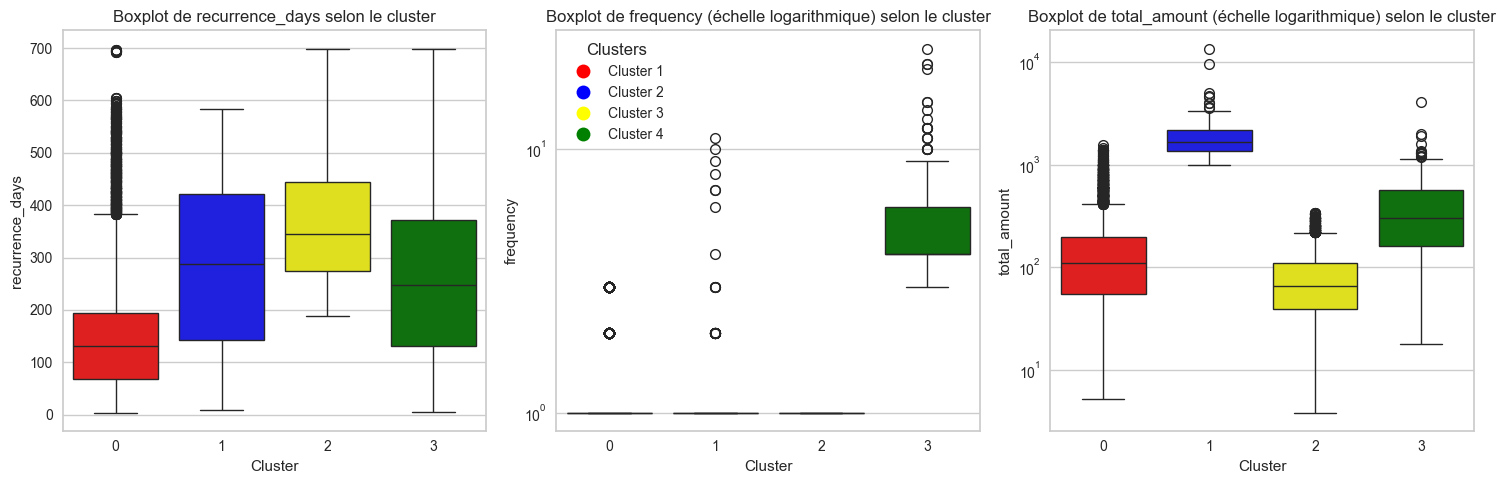

In [191]:

variables = ["recurrence_days", "frequency", "total_amount"]

plt.figure(figsize=(15, 5))  

for i, variable in enumerate(variables):
    plt.subplot(1, len(variables), i + 1)
    
    sns.boxplot(x='hierarchical_cluster', y=variable, data=data2, palette=custom_palette)
    
    if variable in ["frequency", "total_amount"]:
        plt.yscale('log')
        title = f"Boxplot de {variable} (échelle logarithmique) selon le cluster"
    else:
        title = f"Boxplot de {variable} selon le cluster"
    
    plt.title(title)
    plt.xlabel("Cluster")
    plt.ylabel(variable)

    if i == 1:
        plt.legend(handles=legend_elements, title="Clusters", loc='upper left')

plt.tight_layout()
plt.show()


Modèle non choisi car nécessité de faire un sous-échantillonage

## **<a name="C6">6. DBSCAN</a>**

### Préparation des données

In [192]:
data = pd.read_csv("data_RFM.csv", sep=',')

In [193]:
data = data.drop(columns=['customer_unique_id'])

In [194]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), data.select_dtypes(include=['number']).columns)
    ])

In [195]:
X = data.copy()
X_scaled = preprocessor.fit_transform(X)

### Recherche des hyperparamètres optimaux

In [197]:
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(set(labels)) > 1:
        return silhouette_score(X, labels)
    else:
        return -1

param_grid = {
    'eps': np.arange(0.1, 1.0)  
}

dbscan = DBSCAN(min_samples=90)

grid_search = GridSearchCV(dbscan, param_grid, scoring=make_scorer(silhouette_scorer), cv=5)  

grid_search.fit(X_scaled)

print("Meilleur paramètre `eps` :", grid_search.best_params_['eps'])

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^

Meilleur paramètre `eps` : 0.1


In [196]:
dbscan = DBSCAN(eps=0.1, min_samples=90)
clusters = dbscan.fit_predict(X_scaled)

### Détermination des métriques

In [198]:
data3=data.copy()
data3['DBSCAN_cluster'] = clusters

In [ ]:
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  
silhouette_avg = silhouette_score(X_scaled, clusters) if n_clusters > 1 else np.nan
db_index = davies_bouldin_score(X_scaled, clusters) if n_clusters > 1 else np.nan
ch_index = calinski_harabasz_score(X_scaled, clusters) if n_clusters > 1 else np.nan

cluster_counts = data3['DBSCAN_cluster'].value_counts()
cluster_counts_str = cluster_counts.to_dict()

metrics = {
    'Number of Clusters': n_clusters,
    'Silhouette Score': round(silhouette_avg, 2) if not np.isnan(silhouette_avg) else 'N/A',
    'Davies-Bouldin Index': round(db_index, 2) if not np.isnan(db_index) else 'N/A',
    'Calinski-Harabasz Index': round(ch_index, 2) if not np.isnan(ch_index) else 'N/A',
    'Inertia': 'N/A',
    'Cluster Counts': cluster_counts_str
}

metrics_df_4 = pd.DataFrame(metrics)
metrics_df_4

,Number of Clusters,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Inertia,Cluster Counts
0,3,0.26,1.28,7881.57,N/A,84165
-1,3,0.26,1.28,7881.57,N/A,8563
1,3,0.26,1.28,7881.57,N/A,135
2,3,0.26,1.28,7881.57,N/A,125


### Caractérisation des clusters

In [199]:
df_clusters_summary_4 = data3.groupby('DBSCAN_cluster').mean()
df_clusters_summary_4 = df_clusters_summary_4.round(2)
print("Tableau des moyennes des caractéristiques par cluster :")
df_clusters_summary_4

Tableau des moyennes des caractéristiques par cluster :


,recurrence_days,frequency,total_amount
DBSCAN_cluster,,,
-1,282.34,2.15,453.97
0,237.35,1.00,91.90
1,186.13,2.00,102.62
2,381.73,2.00,54.54


/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_21821/1087640832.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_21821/1087640832.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_21821/1087640832.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




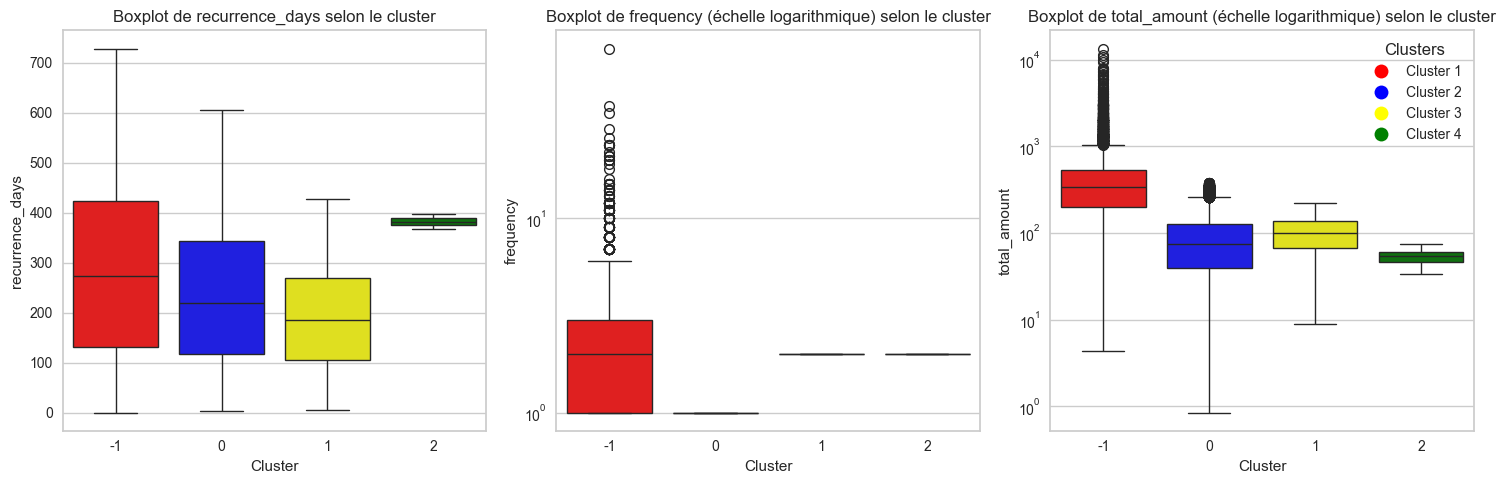

In [200]:
k = len(df_clusters_summary_4)  

cluster_labels = [f'Cluster {i+1}' for i in range(k)]

cluster_colors = ['red', 'blue', 'yellow', 'green']  

legend_elements = [mlines.Line2D([], [], color=color, marker='o', linestyle='', markersize=10, label=label)
                   for color, label in zip(cluster_colors, cluster_labels)]

variables = ["recurrence_days", "frequency", "total_amount"]

plt.figure(figsize=(15, 5)) 

for i, variable in enumerate(variables):
    plt.subplot(1, len(variables), i + 1)
    sns.boxplot(x='DBSCAN_cluster', y=variable, data=data3, palette=cluster_colors)
    plt.title(f"Boxplot de {variable} selon le cluster")


    if variable in ["frequency", "total_amount"]:
        plt.yscale('log')
        plt.title(f"Boxplot de {variable} (échelle logarithmique) selon le cluster")

    plt.xlabel("Cluster")
    plt.ylabel(variable)

    if i == len(variables) - 1: 
        plt.legend(handles=legend_elements, title="Clusters", loc='upper right')

plt.tight_layout()
plt.show()


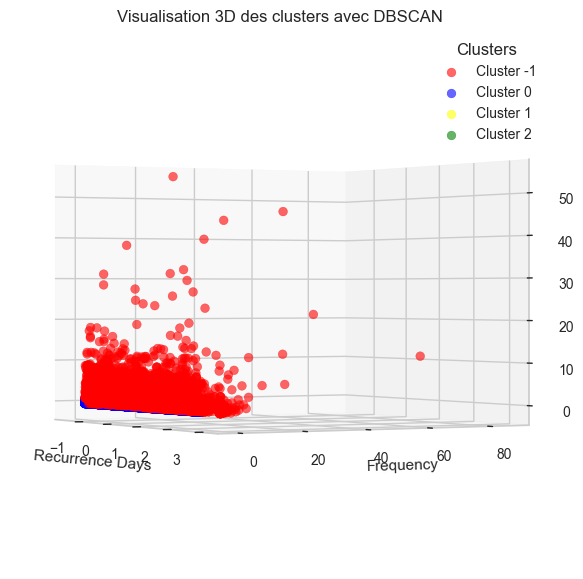

In [201]:
colors = ['red', 'blue', 'yellow', 'green']

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for i, cluster in enumerate(np.unique(clusters)):
    cluster_points = X_scaled[clusters == cluster]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], 
               label=f'Cluster {cluster}', 
               color=colors[i], 
               s=40, alpha=0.6)


ax.view_init(elev=0, azim=-30)  

ax.set_xlabel('Recurrence Days')
ax.set_ylabel('Frequency')
ax.set_zlabel('Total Amount')
ax.set_title('Visualisation 3D des clusters avec DBSCAN')

ax.legend(title="Clusters")

plt.show()


Modèle non choisi car clusters moins bien séparés que ceux générés par Kmeans

Finalement, le choix du modèle clustering est le modèle Kmeans avec K=4, pour les variables RFM et la variable average_review_score